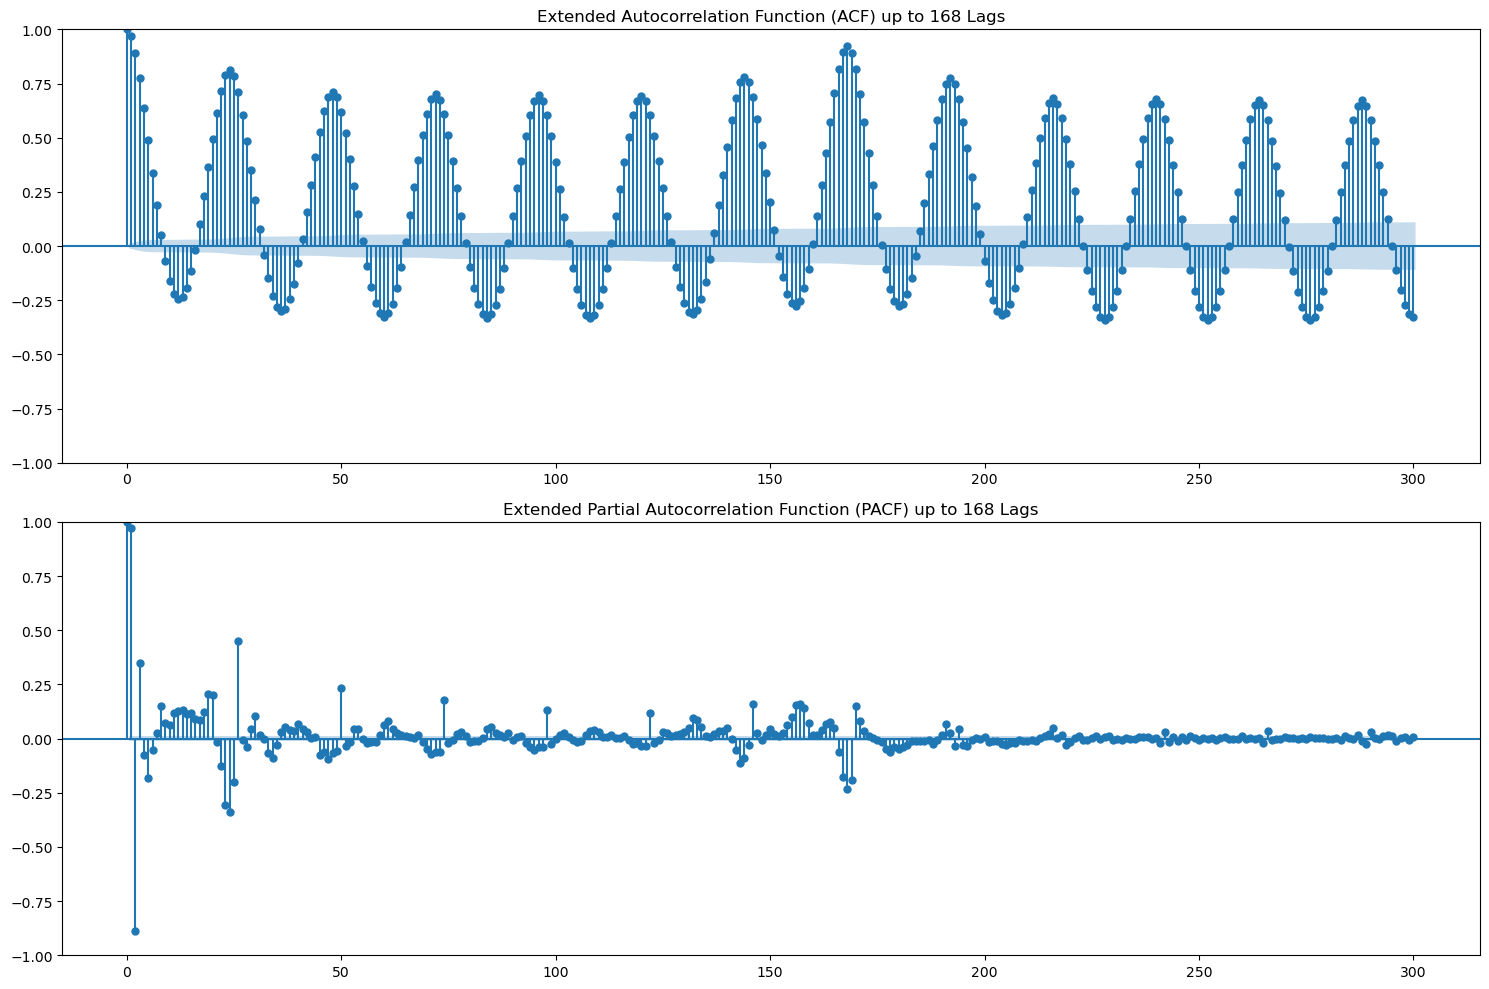

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from statsmodels.tsa.seasonal import seasonal_decompose  # Uncomment if you want to use seasonal decomposition

# Load and concatenate data (modify file paths as necessary)
part1 = pd.read_excel('data/Actuals_part1.xlsx')  # Modify file name and path
part2 = pd.read_csv('data/Actuals_part2.csv')  # Modify file name and path
full_data = pd.concat([part1, part2], ignore_index=True)
full_data['Time'] = pd.to_datetime(full_data['Time'])
full_data = full_data.sort_values(by='Time').reset_index(drop=True)

# Extended ACF and PACF Analysis
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
plot_acf(full_data['Load (kW)'], lags=300, ax=axs[0])
axs[0].set_title('Extended Autocorrelation Function (ACF) up to 168 Lags')
plot_pacf(full_data['Load (kW)'], lags=300, ax=axs[1])
axs[1].set_title('Extended Partial Autocorrelation Function (PACF) up to 168 Lags')
plt.tight_layout()
plt.show()

# Optional: Seasonal Decomposition (uncomment to use)
# decomposed = seasonal_decompose(full_data['Load (kW)'], model='additive', period=168)  # Modify model and period as necessary
# decomposed.plot()
# plt.show()

# Optional: Feature Importance Analysis (uncomment and modify to use with your model)
# feature_importances = your_model.feature_importances_  # Replace 'your_model' with your actual model
# plt.bar(range(len(feature_importances)), feature_importances)
# plt.title('Feature Importance')
# plt.show()

# Optional: Model Performance with Different Lags (uncomment and modify to use with your model training and evaluation code)
# for lags in [24, 48, 72, 96, 120, 144, 168]:  # Modify the list of lags as necessary
#     # Train and evaluate your model with 'lags' number of lags, and store the performance metric
#     performance = train_and_evaluate_model(lags)  # Replace with your model training and evaluation function
#     print(f'Performance with {lags} lags: {performance}')


ACF (Autocorrelation Function):

The significant spikes at lags 24, 48, 72, 96, 120, 144, and 168 indicate strong daily seasonality. Each of these lags corresponds to a multiple of 24 hours, suggesting that the electricity load has a repeating pattern every day.
The sustained significance of these lags up to 168 hours (7 days) suggests that there is also weekly seasonality or at least weekly patterns that are worth capturing in the model.
PACF (Partial Autocorrelation Function):

The significant spike at lag 168 specifically suggests that, after accounting for the correlation at shorter lags, there is still notable correlation between the load and its value 7 days prior. This indicates that the load value at a given hour is directly influenced by the load value at the same hour a week earlier.
Justification for Using 168 Lags:
The significant autocorrelations at lags 24, 48, 72, 96, 120, 144, and 168 in the ACF plot justify using these lags as features in your model to capture daily patterns.
The spike at lag 168 in the PACF plot further supports the use of 168 lags to capture weekly patterns.
Using 168 lags allows the model to have access to the previous week's worth of hourly data, which can be crucial for capturing both daily and weekly seasonality in the electricity load.

In [2]:
from sklearn.feature_selection import mutual_info_regression

# Drop time column for correlation analysis
data_for_correlation = full_data.drop(columns=['Time'])

# Compute correlation of each feature with the target variable (load)
correlation_with_load = data_for_correlation.corr()['Load (kW)'].sort_values(key=abs, ascending=False)

# Display correlations
correlation_with_load

# Prepare features and target variable
X = data_for_correlation.drop(columns=['Load (kW)'])
y = data_for_correlation['Load (kW)']

# Compute mutual information
mutual_info = mutual_info_regression(X, y)
mi_series = pd.Series(mutual_info, index=X.columns).sort_values(ascending=False)

# Print mutual information
print(mi_series)


Temperature (C)         0.261762
Wind Speed (kmh)        0.146837
Wind Direction (deg)    0.118361
Humidity (%)            0.082041
Cloud Cover (%)         0.066102
Pressure_kpa            0.057199
dtype: float64


Close to 0: The variables are independent or have very weak dependency.
Intermediate Values: There's some dependency between the variables. It's hard to define a concrete range for "high" mutual information as it depends on the context and the specific domain you are working with. Generally, if the mutual information is significantly higher than 0, it suggests some dependency.
Close to 1: Strong dependency between the variables. For continuous variables, the value can technically be more than 1, but in practice, values above 0.5 are often considered high.

In [3]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and train a Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=0)
model.fit(X, y)

# Extract feature importances
feature_importances = model.feature_importances_
fi_series = pd.Series(feature_importances, index=X.columns).sort_values(ascending=False)

# Print feature importances
print(fi_series)


Temperature (C)         0.405992
Wind Speed (kmh)        0.171977
Wind Direction (deg)    0.117609
Pressure_kpa            0.116029
Humidity (%)            0.097939
Cloud Cover (%)         0.090453
dtype: float64


Close to 0: The feature is not important for making predictions.
Intermediate Values: Features with intermediate importance values make a moderate contribution to the predictions. It's difficult to define a threshold for "high" importance without context, as it depends on the distribution of importance values across all features.
Close to 1: The feature is very important for predictions.